# 목표

- 정상적인 사용자와 분산형 크롤러를 구분 가능한지 확인한다.


# 순서

1. 웹 트래픽 데이터를 로드한다.
2. 전반부 N일과 후반부 30-N일을 분리한다.
3. 전반부 N일로 td3 영역을 체크한다. 0회 접근한 아이템 까지 포함한다.
4. 후반부 30-N일 트래픽으로 false positive를 확인한다.
5. 크롤러로 true positive를 확인한다.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
import anti_crawler as ac

In [3]:
a = ac.AntiCrawl()

Loading access_log_jul95.csv
Removing failed requests..
Adding day column..
Load Complete 1701011 items


# Get long-tail item data frame

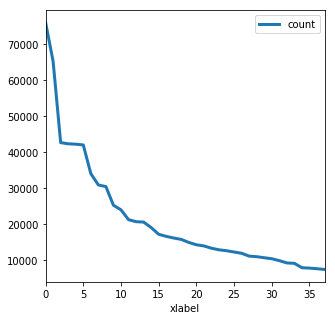

count       38.000000
mean     21250.947368
std      15859.346650
min       7326.000000
25%      10912.750000
50%      15254.000000
75%      24852.750000
max      76040.000000
Name: count, dtype: float64


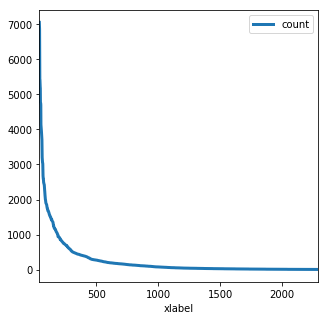

count    2256.000000
mean      264.886082
std       630.802071
min         9.000000
25%        21.000000
50%        53.000000
75%       203.000000
max      7043.000000
Name: count, dtype: float64


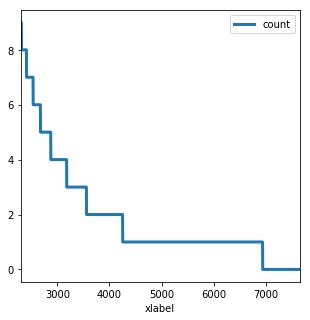

count    5355.000000
mean        1.882353
std         1.860963
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: count, dtype: float64
Count: 5355 / 7649


In [4]:
train_until = 23
td3 = a.get_td3(train_until, _label=[0.005, 0.1, 0.3])

# Simulator Functions
- Crawler Set Node Reducing Simulator
- Web Traffic Node Reducing False Positive Checker

In [13]:
def simulate(crawl_num, df, item_list, threshold, except_item=".gif", _plot=True):
    result = dict()
    attacker_ip = [x for x in range(crawl_num)]
    server_mem = dict()
    
    td3_list = df[df['count'] <= threshold]['uri'].values

    aip = 0
    
    for pos, item in enumerate(item_list):
        laip = len(attacker_ip)
        
        result[pos] = laip
        
        if laip < 1:
            continue
            
        aip = (aip + 1) % laip
        
        if item.lower().endswith(except_item):
            continue
            
        if item not in td3_list:
            continue
            
        atkip = attacker_ip[aip]

        if atkip not in server_mem:
            server_mem[atkip] = [item]
        elif item not in server_mem[atkip]:
            server_mem[atkip].append(item)

        if len(server_mem[atkip]) >  threshold:
            attacker_ip.remove(atkip)       
    
    if _plot:
        df_result = pd.DataFrame.from_dict(result, orient='index')
        ax = df_result.plot()
        ax.legend(["number of nodes"])
        plt.show()
    
    return laip


def simulate_real(df_traffic, df_td3, threshold, except_item=".gif", _plot=False):
    result = dict()
    server_mem = dict()
    banned = list()
    server_mem = dict()
    
    td3_list = df_td3[df_td3['count'] <= threshold]['uri'].values
    
    print("Td3 list len: %d" % len(td3_list))
    print(td3_list)
    
    n = 0
    
    for item in df_traffic.iterrows():
        uri = str(item[1].URI)
        ip = item[1].IP
        
        result[n] = len(banned)
        n += 1
        
        if ip in banned:
            continue
            
        if uri.lower().endswith(except_item):
            continue
        
        if uri not in td3_list:
            continue
            
        if ip not in server_mem:
            server_mem[ip] = [uri]
        elif uri not in server_mem[ip]:
            server_mem[ip].append(uri)
        
        if len(server_mem[ip]) > threshold:
            banned.append(ip)
            print(banned)
            
    if _plot:
        df_result = pd.DataFrame.from_dict(result, orient='index')
        df_result.plot()
        plt.show()
    
    return banned, server_mem
        
        

# Simulate Node Reducing

7649
(5355, 4)


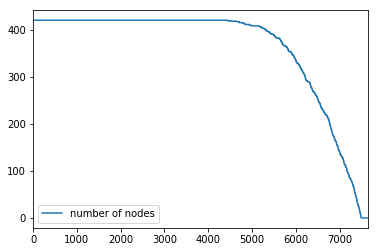

0


In [32]:

threshold = 10
except_item = '.gif'

df_count = a.get_item_count(a.df)

item_list = df_count['uri'].tolist()
random.shuffle(item_list)

print(len(item_list))
print(td3.shape)

# result = simulate(50, td3, item_list, threshold, except_item=except_item)
# print(result)

# result = simulate(100, td3, item_list, threshold, except_item=except_item)
# print(result)

# result = simulate(222, td3, item_list, threshold, except_item=except_item)
# print(result)

# result = simulate(300, td3, item_list, threshold, except_item=except_item)
# print(result)


result = simulate(420, td3, item_list, threshold, except_item=except_item)
print(result)


7649
(5355, 4)


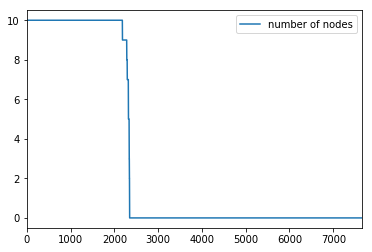

0


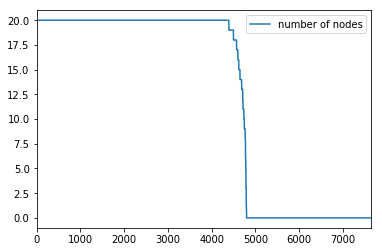

0


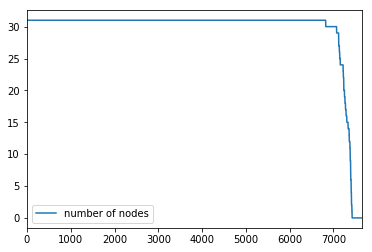

0


In [20]:

threshold = 185
except_item = '.gif'

df_count = a.get_item_count(a.df)

item_list = df_count['uri'].tolist()
random.shuffle(item_list)

print(len(item_list))
print(td3.shape)

result = simulate(10, a.df_tdall, item_list, threshold, except_item=except_item)
print(result)

result = simulate(20, a.df_tdall, item_list, threshold, except_item=except_item)
print(result)

result = simulate(31, a.df_tdall, item_list, threshold, except_item=except_item)
print(result)

# Simulate Web Traffic with Node Reducing Algorithm

In [7]:
gr_traffic = a.df[a.df.day > (train_until - 1)].groupby('day')

In [33]:
banned_list = list()
with open("day_traffic_fp.csv", 'w', encoding='utf-8') as fo:
    fo.write("DAY|NUM_TRFC|NUM_BANNED|NUM_IP|FP_RATE|BANNED_LIST\n")
    for day, df_trf in gr_traffic:  
        banned, serv_mem = simulate_real(df_trf, td3, threshold, except_item=except_item)
        banned_list += banned
        num_banned = len(banned)
        num_traffic = df_trf.shape[0]
        
        day_ip = df_trf['IP'].nunique()
        
        if day_ip == 0:
            continue
        
        wline = "%d|%d|%d|%d|%f|%s\n" % (day, num_traffic, num_banned, day_ip, (num_banned / day_ip), ",".join(banned))
        print(wline)
        
        fo.write(wline)
        print("---------------------------")

Td3 list len: 5355
['/shuttle/missions/sts-70/images/captions.txt'
 '/history/apollo/apollo-13/sounds/a13_002.wav"'
 '/shuttle/missions/51-f/51-f-info.html' ...,
 '/shuttle/missions/sts-35/images/90HC731.GIF'
 '/shuttle/missions/sts-35/images/90HC708.GIF'
 '/images/cdrom-1-95/img0044.jpg']
['netport-9.iu.net']
['netport-9.iu.net', 'dialup8.afn.org']
23|36125|2|2575|0.000777|netport-9.iu.net,dialup8.afn.org

---------------------------
Td3 list len: 5355
['/shuttle/missions/sts-70/images/captions.txt'
 '/history/apollo/apollo-13/sounds/a13_002.wav"'
 '/shuttle/missions/51-f/51-f-info.html' ...,
 '/shuttle/missions/sts-35/images/90HC731.GIF'
 '/shuttle/missions/sts-35/images/90HC708.GIF'
 '/images/cdrom-1-95/img0044.jpg']
['jbiagioni.npt.nuwc.navy.mil']
['jbiagioni.npt.nuwc.navy.mil', 'dwkm206.usa1.com']
['jbiagioni.npt.nuwc.navy.mil', 'dwkm206.usa1.com', 'dd09-014.compuserve.com']
['jbiagioni.npt.nuwc.navy.mil', 'dwkm206.usa1.com', 'dd09-014.compuserve.com', 'ad04-003.compuserve.com']
[

In [16]:
banned_list = list()
with open("day_traffic_fp.csv", 'w', encoding='utf-8') as fo:
    fo.write("DAY|NUM_TRFC|NUM_BANNED|NUM_IP|FP_RATE|BANNED_LIST\n")
    for day, df_trf in gr_traffic:  
        banned, serv_mem = simulate_real(df_trf, a.df_tdall, threshold, except_item=except_item)
        banned_list += banned
        num_banned = len(banned)
        num_traffic = df_trf.shape[0]
        
        day_ip = df_trf['IP'].nunique()
        
        if day_ip == 0:
            continue
        
        wline = "%d|%d|%d|%d|%f|%s\n" % (day, num_traffic, num_banned, day_ip, (num_banned / day_ip), ",".join(banned))
        print(wline)
        
        fo.write(wline)
        print("---------------------------")

Td3 list len: 7006
['/facts/launch-pass.txt'
 '/shuttle/missions/sts-70/images/KSC-95EC-0705.jpg'
 '/msfc/onboard/come_aboard.gif' ...,
 '/shuttle/missions/sts-35/images/90HC731.GIF'
 '/shuttle/missions/sts-35/images/90HC708.GIF'
 '/images/cdrom-1-95/img0044.jpg']
23|36125|0|2575|0.000000|

---------------------------
Td3 list len: 7006
['/facts/launch-pass.txt'
 '/shuttle/missions/sts-70/images/KSC-95EC-0705.jpg'
 '/msfc/onboard/come_aboard.gif' ...,
 '/shuttle/missions/sts-35/images/90HC731.GIF'
 '/shuttle/missions/sts-35/images/90HC708.GIF'
 '/images/cdrom-1-95/img0044.jpg']
24|58183|0|4223|0.000000|

---------------------------
Td3 list len: 7006
['/facts/launch-pass.txt'
 '/shuttle/missions/sts-70/images/KSC-95EC-0705.jpg'
 '/msfc/onboard/come_aboard.gif' ...,
 '/shuttle/missions/sts-35/images/90HC731.GIF'
 '/shuttle/missions/sts-35/images/90HC708.GIF'
 '/images/cdrom-1-95/img0044.jpg']
['jbiagioni.npt.nuwc.navy.mil']
25|57102|1|4321|0.000231|jbiagioni.npt.nuwc.navy.mil

---------

In [35]:
# 전체 차단 IP
banned_list = list(set(banned_list))

print(len(banned_list))
banned_list

27


['156.80.168.122',
 'netport-9.iu.net',
 'n1388866.ksc.nasa.gov',
 'chop.isca.uiowa.edu',
 '199.201.186.102',
 'lecp04.eng.miami.edu',
 'ad04-003.compuserve.com',
 'dd09-014.compuserve.com',
 '163.205.180.17',
 'scooter.pa-x.dec.com',
 'sputnix.cas.und.nodak.edu',
 'titan',
 'adder.cee.hw.ac.uk',
 'ix-sd10-24.ix.netcom.com',
 '199.93.170.211',
 'walt.cfr.washington.edu',
 'ppp3_153.bekkoame.or.jp',
 'dwkm206.usa1.com',
 'freenet.edmonton.ab.ca',
 'leo.dafa.se',
 '141.102.82.73',
 'dialup8.afn.org',
 'sw25-157.iol.it',
 'jalisco.engr.ucdavis.edu',
 'jbiagioni.npt.nuwc.navy.mil',
 '163.206.89.4',
 'internet-gw.ford.com']

In [ ]:
df_day_trfc = pd.read_csv("day_traffic_fp.csv", sep='|', encoding='utf-8')
df_day_trfc

In [ ]:
df_day_trfc.describe()

In [ ]:
gr_ip = a.df.groupby('IP')

In [ ]:
for ip, df_ip in gr_ip:
    if ip not in banned_list:
        continue
    
    print("%s: %d" % (ip, df_ip.shape[0]))

In [ ]:
td3['is_td3'] = True
wierd_ip = 'sputnix.cas.und.nodak.edu'
df_tagged = pd.merge(a.df, td3, how='outer', left_on='URI', right_on='uri')[['IP','URI', 'RESULT', 'day', 'is_td3']]
# a.df[(a.df['IP'] == 'jbiagioni.npt.nuwc.navy.mil') & (a.df['day'] > (train_until - 1))]
df_fp_td3 = df_tagged[(df_tagged['IP'] == wierd_ip) & (df_tagged['day'] > (train_until - 1)) & (df_tagged['is_td3'] == True)]
df_fp_all = df_tagged[(df_tagged['IP'] == wierd_ip) & (df_tagged['day'] > (train_until - 1))]

print("%s - td3: %d / all: %d (%f)" % (wierd_ip, df_fp_td3.shape[0], df_fp_all.shape[0], df_fp_td3.shape[0] / df_fp_all.shape[0]))
df_fp_td3

In [ ]:
df_fp_td3['URI'].nunique()

In [ ]:
def parse_uri(_uri):
    if _uri.endswith('/'):
        return '/'
    
    file_name = _uri.split('/')[-1]
    
    if '.' not in file_name:
        return 'no_ext'
    
    return file_name.split('?')[0].split('.')[-1]

# a.df['ext'] = a.df['URI'].apply(lambda x: parse_uri(x))
df_all = a.get_item_count(a.df[['URI', 'IP', 'day']])
df_all['ext'] = df_all['uri'].apply(lambda x: parse_uri(x))

df_all

# Show percentage of long-tail item

In [ ]:
df_tagged = pd.merge(df_all, td3, how='outer', left_on='uri', right_on='uri')[['uri', 'is_td3', 'ext']]
df_tagged = df_tagged.fillna(False)

gr_ext = df_tagged.groupby('ext')

def sort_func(x):
    return x[1].shape[0]

gr_ext = sorted(gr_ext, key=lambda x: sort_func(x), reverse=True)

for ext, df_ext in gr_ext:
    num_true = df_ext[df_ext['is_td3'] == True].shape[0]
    num_false = df_ext[df_ext['is_td3'] == False].shape[0]
    num_total = num_true + num_false
    print("%s: %d / %d (%0.f %%)" % (ext, num_true, num_total, num_true * 100 / num_total))